In [1]:
import tensorflow as tf
import cleverhans
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastFeatureAdversaries

import numpy as np
import scipy
import keras
from keras import backend as K
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions

sess = K.get_session()
K.set_session(sess)

kmodel = ResNet50(weights='imagenet')
wrap = KerasModelWrapper(kmodel)

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import *
def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

def get_img_and_process(img_path):
    img = load_img(img_path)
    img_arr = img_to_array(img)
    img_arr = img_arr[np.newaxis, :]
    img_arr = resize_img(img_arr, (224, 224, 3))
    return preprocess_input(img_arr)

vitruvian = get_img_and_process("../imgs/vitruvian.jpg")
wolf = get_img_and_process("../imgs/wolf.jpg")

In [3]:
from cleverhans.attacks import FastGradientMethod
fgsm = FastGradientMethod(wrap, sess=sess)
x_adv = fgsm.generate(kmodel.input)
x_adv = tf.stop_gradient(x_adv)
feed_dict = {kmodel.input: vitruvian}
fgsm_res = sess.run(x_adv, feed_dict=feed_dict)

885
0.08221945


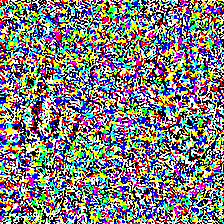

In [4]:
print(np.argmax(kmodel.predict(fgsm_res)[0]))
print(np.max(kmodel.predict(fgsm_res)[0]))
array_to_img(fgsm_res[0] - vitruvian[0])

In [5]:
from cleverhans.attacks import CarliniWagnerL2
cwl2 = CarliniWagnerL2(model=wrap, sess=sess, targeted=True, confidence=20)
wolf_target = np.zeros((1, 1000))
wolf_target[0, 269] = 1
cwl2_args = {'y_target': wolf_target,
             'confidence': 25, 
             'learning_rate': 0.01, 
             'binary_search_steps': 10, 
             'initial_const': 0.7, 
             'clip_min': 0, 
             'clip_max': 255}
cwl2_adv = cwl2.generate(kmodel.input, **cwl2_args)
cwl2_adv = tf.stop_gradient(cwl2_adv)
feed_dict = {kmodel.input: vitruvian}
cwl2_res = sess.run(cwl2_adv, feed_dict=feed_dict)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


549
0.14708458


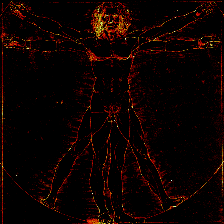

In [6]:
print(np.argmax(kmodel.predict(cwl2_res)[0]))
print(np.max(kmodel.predict(cwl2_res)[0]))
array_to_img(cwl2_res[0] - vitruvian[0])

In [34]:
from cleverhans.attacks import FastGradientMethod
x_adv_2 = fgsm.generate(kmodel.input, y_target=wolf_target, eps=2.8)
x_adv_2 = tf.stop_gradient(x_adv_2)
feed_dict_2 = {kmodel.input: vitruvian}
fgsm_res_2 = sess.run(x_adv_2, feed_dict=feed_dict)

972
0.16768727
0.002203416


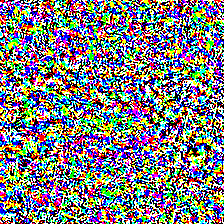

In [35]:
print(np.argmax(kmodel.predict(fgsm_res_2)[0]))
print(np.max(kmodel.predict(fgsm_res_2)[0]))
print(kmodel.predict(fgsm_res_2)[0, 269])
array_to_img(fgsm_res_2[0] - vitruvian[0])

In [39]:
from cleverhans.attacks import DeepFool
df = DeepFool(wrap, sess=sess)
df_adv = df.generate(kmodel.input, max_iter=100)
df_adv = tf.stop_gradient(df_adv)
df_res = sess.run(df_adv, feed_dict=feed_dict)

[INFO 2019-02-17 17:03:21,343 cleverhans] Attack result at iteration 1 is [111]
[INFO 2019-02-17 17:03:21,344 cleverhans] 1 out of 1 become adversarial examples at iteration 1


111
0.0956886


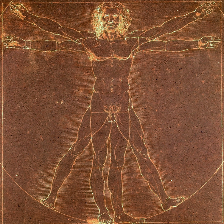

In [40]:
print(np.argmax(kmodel.predict(df_res)[0]))
print(np.max(kmodel.predict(df_res)[0]))
array_to_img(df_res[0] - vitruvian[0])

In [42]:
fgsm_res[0].dump('fgsm.npy')
cwl2_res[0].dump('cwl2.npy')
fgsm_res_2[0].dump('target_fgsm.npy')
df_res[0].dump('deepfool.npy')